In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import mne
from mne.datasets import sample
from mne import make_fixed_length_epochs
from mne.time_frequency import psd_array_welch
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)
import seaborn as sns

In [48]:
dir = 'ds004504'
num = 'sub-001'
num_sub = 'sub-001/eeg/sub-001_task-eyesclosed_eeg.set'
data_path = f'{dir}/{num_sub}'

data_paths = []
eeg = '/eeg/'
task = '_task-eyesclosed_eeg.set'
num = ''

'''
with open('participant_list.txt','r') as file:
    for line in file:
        num = line.rstrip()
        data_paths.append(f'{dir}/{num}{eeg}{num}{task}')

'''

"\nwith open('participant_list.txt','r') as file:\n    for line in file:\n        num = line.rstrip()\n        data_paths.append(f'{dir}/{num}{eeg}{num}{task}')\n\n"

In [49]:
raw = mne.io.read_raw_eeglab(data_path, preload=True)
raw = raw.filter(2, 20)
duration = 4 
overlap = 0.5 
epochs = make_fixed_length_epochs(raw, duration=duration, overlap=overlap, preload=True)
data = epochs.get_data()
times = epochs.times

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 s)

Not setting metadata
171 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 171 events and 2000 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/cr/xdpvycqd5m5gw89n5v0tx1x80000gn/T/ipykernel_980/270352711.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


In [50]:
n_fft = 2000
n_overlap = n_fft // 2
sfreq = raw.info['sfreq']
psd_list = []
freqs_list = []

for epoch_data in data:
    psd, freqs = psd_array_welch(epoch_data, sfreq=sfreq, n_fft=n_fft, n_overlap=n_overlap)
    psd_list.append(psd)
    freqs_list.append(freqs)

psd = np.array(psd_list)
freqs = np.array(freqs_list)[0]

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective wind

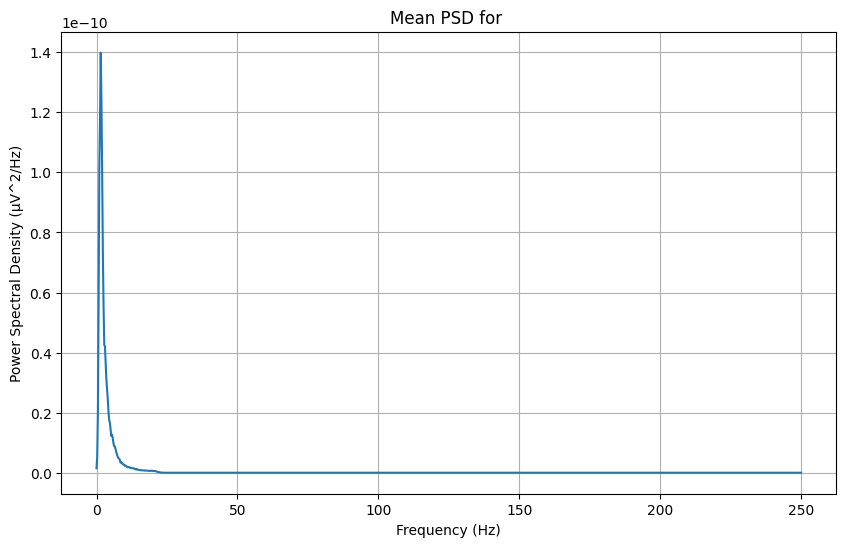

In [51]:
mean_psd = np.mean(psd, axis=(0, 1))

plt.figure(figsize=(10, 6))
plt.plot(freqs, mean_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (μV^2/Hz)')
plt.title(f'Mean PSD for {num}')
plt.grid()
plt.show()

In [52]:

psd_mean_list = []
for data_path in data_paths:
    raw = mne.io.read_raw_eeglab(data_paths[0], preload=True)
    raw = raw.filter(2, 20)
    duration = 4 
    overlap = 0.5 
    epochs = make_fixed_length_epochs(raw, duration=duration, overlap=overlap, preload=True)
    data = epochs.get_data()
    times = epochs.times

    n_fft = 2000
    n_overlap = n_fft // 2
    sfreq = raw.info['sfreq']
    psd_list = []
    freqs_list = []

    for epoch_data in data:
        psd, freqs = psd_array_welch(epoch_data, sfreq=sfreq, n_fft=n_fft, n_overlap=n_overlap)
        psd_list.append(psd)
        freqs_list.append(freqs)

    psd = np.array(psd_list)
    freqs = np.array(freqs_list)[0]

    mean_psd = np.mean(psd, axis=(0, 1))
    psd_mean_list.append(max(mean_psd))


In [53]:
'''
def mean_in_range(data_list, min_val, max_val):
    numbers_in_range = [num for num in data_list if min_val <= num <= max_val]
    if numbers_in_range: 
        return sum(numbers_in_range) / len(numbers_in_range)
    else:
        return None
mean_list_1 = mean_in_range(psd_mean_list, 1, 35)
mean_list_2 = mean_in_range(psd_mean_list, 37, 64)
mean_list_3 = mean_in_range(psd_mean_list, 66, 87)
print(mean_list_1)
'''


'\ndef mean_in_range(data_list, min_val, max_val):\n    numbers_in_range = [num for num in data_list if min_val <= num <= max_val]\n    if numbers_in_range: \n        return sum(numbers_in_range) / len(numbers_in_range)\n    else:\n        return None\nmean_list_1 = mean_in_range(psd_mean_list, 1, 35)\nmean_list_2 = mean_in_range(psd_mean_list, 37, 64)\nmean_list_3 = mean_in_range(psd_mean_list, 66, 87)\nprint(mean_list_1)\n'

In [54]:
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 25),
    'Gamma': (25, 45)
}
def get_band_power(psd, freqs, band):
    band_freqs = (freqs >= band[0]) & (freqs <= band[1])
    band_psd = psd[:, :, band_freqs].mean(axis=2)
    return band_psd
psd_bands = {band: get_band_power(psd, freqs, band_range) for band, band_range in freq_bands.items()}
total_band = (0.5, 45)
total_psd = get_band_power(psd, freqs, total_band)
total_psd_mean = total_psd.mean(axis=1)

rbp = {}
for band, band_psd in psd_bands.items():
    rbp[band] = band_psd / total_psd_mean[:, np.newaxis]

feature_matrix = np.vstack([rbp[band].mean(axis=1) for band in freq_bands])
feature_matrix = feature_matrix.T
